# Ghost Vs No Ghost ~ all frequencies: BNP01B

In [1]:
import matplotlib
# matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
from BCI2kReader import BCI2kReader as b2k
import os
import mne
from tabulate import tabulate
import IPython
import seaborn as sns
import scipy
import joblib

import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest

# Import required code for visualizing example models
from fooof import FOOOF
from fooof.sim.gen import gen_power_spectrum
from fooof.sim.utils import set_random_seed
from fooof.plts.spectra import plot_spectra
from fooof.plts.annotate import plot_annotated_model
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from neurodsp.plts.spectral import plot_power_spectra



In [2]:
## Prep paths ##

subject = 'BNP01B'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}"
preproc_data_dir = f"/home/brooke/pacman/preprocessing/{subject}/ieeg"

In [3]:
## Load Neural Data

# load
last_away_ecpohs = mne.read_epochs(f"{preproc_data_dir}/{subject}_bp_raw_clean_last_away_events.fif")

# get good epochs (for behavioral data only)
good_epochs = [i for i,x in enumerate(last_away_ecpohs.get_annotations_per_epoch()) if not x]
bad_epochs = [i for i,x in enumerate(last_away_ecpohs.get_annotations_per_epoch()) if  x]

# onlt good epochs
last_away_ecpohs = last_away_ecpohs[good_epochs]

# load behavioral data
last_away_data = pd.read_csv(f"{raw_data_dir}/behave/{subject}_last_away_events.csv")

## Prep Behavioral Data
last_away_data['trial_numeric'] = last_away_data['trial_numeric'] - 1
last_away_data = last_away_data[last_away_data.index.isin(good_epochs)]

# set info as metadata
last_away_ecpohs.metadata = last_away_data

Reading /home/brooke/pacman/preprocessing/BNP01B/ieeg/BNP01B_bp_raw_clean_last_away_events.fif ...
Isotrak not found
    Found the data of interest:
        t =   -5000.00 ...    5000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
174 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 5 columns


/tmp/ipykernel_219031/870373520.py:4: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BNP01B/ieeg/BNP01B_bp_raw_clean_last_away_events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  last_away_ecpohs = mne.read_epochs(f"{preproc_data_dir}/{subject}_bp_raw_clean_last_away_events.fif")


In [4]:
# separate ghost and no ghost trials

ghost_epochs = last_away_ecpohs["TrialType <= 16"]
no_ghost_epochs = last_away_ecpohs["TrialType > 16"]

In [6]:
## Dictionary of electrode locations ##

hc_list = ['LHip3 - LHip4', 'RHip3 - RHip4']
hc_indices = [0, 1]



In [7]:
def MM_compute_TFR(epochs, freqs, n_cycles, baseline, zscore=True, time_bandwidth=None):
    print('computing TFR')
    TFR = mne.time_frequency.tfr_morlet(epochs,freqs,n_cycles,return_itc=False,
                                            average=False,  n_jobs = 8)
    print('log transforming')
    TFR.data = np.log(TFR.data)
    if zscore:
        print('z-scoring to baseline')
        bix = [a and b  for a, b in zip(TFR.times >= baseline[0], TFR.times <= baseline[1])]
        bmean = TFR.data[:,:,:,bix].mean(axis=(3),keepdims=True)
        bstd = TFR.data[:,:,:,bix].std(axis=(3),keepdims=True)
        TFR.data = (TFR.data - bmean) / bstd
    return TFR

def MM_compute_TFR_ratio(epochs, freqs, n_cycles, baseline, zscore=True, time_bandwidth=None):
    print('computing TFR')
    TFR = mne.time_frequency.tfr_morlet(epochs,freqs,n_cycles,return_itc=False,
                                            average=False,  n_jobs = 8)
    print('log transforming')
    if zscore:
        print('z-scoring to baseline')
        bix = [a and b  for a, b in zip(TFR.times >= baseline[0], TFR.times <= baseline[1])]
        bmean = TFR.data[:,:,:,bix].mean(axis=(0,3),keepdims=True)
        TFR.data = TFR.data/bmean

    return TFR

def MM_compute_TFR_logratio(epochs, freqs, n_cycles, baseline, zscore=True, time_bandwidth=None):
    print('computing TFR')
    TFR = mne.time_frequency.tfr_morlet(epochs,freqs,n_cycles,return_itc=False,
                                            average=False,  n_jobs = 8)
    print('log transforming')
    if zscore:
        print('z-scoring to baseline')
        bix = [a and b  for a, b in zip(TFR.times >= baseline[0], TFR.times <= baseline[1])]
        bmean = TFR.data[:,:,:,bix].mean(axis=(0,3),keepdims=True)
        TFR.data = TFR.data/bmean
        TFR.data = np.log(TFR.data) 
                                            
    return TFR

def MM_compute_TFR_zlogratio(epochs, freqs, n_cycles, baseline, zscore=True, time_bandwidth=None):
    print('computing TFR')
    TFR = mne.time_frequency.tfr_morlet(epochs,freqs,n_cycles,return_itc=False,
                                            average=False,  n_jobs = 8)
    print('log transforming')
    if zscore:
        print('z-scoring to baseline')
        bix = [a and b  for a, b in zip(TFR.times >= baseline[0], TFR.times <= baseline[1])]
        bmean = TFR.data[:,:,:,bix].mean(axis=(0,3),keepdims=True)
        TFR.data = TFR.data/bmean
        TFR.data = np.log(TFR.data) 
        bstd = TFR.data[:,:,:,bix].std(axis=(0,3),keepdims=True)
        TFR.data = TFR.data/ bstd
    return TFR


def stockwell_TFR_ratio(epochs, fmin, fmax, baseline, zscore=True):
    print('computing TFR')
    TFR = mne.time_frequency.tfr_stockwell(epochs,fmin,fmax,return_itc=False,
                                            n_jobs = 8)
    print('log transforming')
    if zscore:
        print('z-scoring to baseline')
        bix = [a and b  for a, b in zip(TFR.times >= baseline[0], TFR.times <= baseline[1])]
        bmean = TFR.data[:,:,bix].mean(axis=(0,3),keepdims=True)
        TFR.data = TFR.data/bmean

    return TFR

In [14]:
# Set frequencies

freqs = np.logspace(start = np.log10(1), stop = np.log10(150), num = 80, base = 10, endpoint = True)
n_cycles = np.logspace(np.log10(2), np.log10(30), base = 10, num = 80)


n_cycles = n_cycles[freqs < 100]
freqs = freqs[freqs < 100]

# formulas to check bandwidth and time bin
band_width = (freqs / n_cycles) * 2
time_bin = n_cycles / freqs / np.pi
print(freqs)
print(n_cycles)
print(time_bin)
print(band_width)


[ 1.          1.06548039  1.13524845  1.20958496  1.28878905  1.37317945
  1.46309577  1.55889984  1.6609772   1.76973863  1.8856218   2.00909304
  2.14064922  2.28081976  2.43016872  2.5892971   2.75884527  2.93949552
  3.13197482  3.33705774  3.55556956  3.78838962  4.03645484  4.30076345
  4.5823791   4.88243505  5.20213877  5.54277682  5.90571998  6.2924288
  6.70445946  7.14347005  7.61122722  8.10961331  8.64063391  9.20642595
  9.80926626 10.45158079 11.13595433 11.8651409  12.6420749  13.46988283
 14.35189595 15.29166362 16.29296764 17.35983743 18.49656627 19.70772855
 20.99819821 22.37316831 23.83817199 25.39910467 27.06224782 28.83429423
 30.72237491 32.73408785 34.87752853 37.16132253 39.59466023 42.18733383
 44.94977669 47.89310538 51.02916436 54.37057369 57.93077979 61.72410955
 65.76582801 70.07219975 74.66055437 79.54935622 84.75827869 90.30828341
 96.22170458]
[ 2.          2.06974683  2.14192598  2.21662225  2.29392345  2.37392039
  2.45670711  2.54238088  2.63104239  

### Hippocampus

In [9]:
hc_list

['LHip3 - LHip4', 'RHip3 - RHip4']

In [10]:
ghost_hc = ghost_epochs.copy().pick_channels(hc_list)
no_ghost_hc = no_ghost_epochs.copy().pick_channels(hc_list)

In [11]:
ghost_hc.metadata.trial_numeric

1        2
2        3
3        4
4        5
5        6
      ... 
163    168
165    170
166    171
167    172
168    173
Name: trial_numeric, Length: 121, dtype: int64

In [15]:
ghost_TFR = MM_compute_TFR(ghost_hc,freqs,n_cycles,baseline = (-2,2), zscore=True)
no_ghost_TFR = MM_compute_TFR(no_ghost_hc,freqs,n_cycles,baseline = (-2,2), zscore=True)

computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Adding metadata with 5 columns


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.0s finished


log transforming
z-scoring to baseline
computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Adding metadata with 5 columns
log transforming
z-scoring to baseline


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s finished


In [16]:
ghost_TFR.crop(tmin = -2, tmax = 2)
no_ghost_TFR.crop(tmin = -2, tmax = 2)

<EpochsTFR | time : [-2.000000, 2.000000], freq : [1.000000, 96.221705], epochs : 32, channels : 2, ~35.7 MB>

In [17]:
ghost_TFR.data.shape

(143, 10, 80, 4001)

/tmp/ipykernel_219031/2968231670.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_219031/2968231670.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


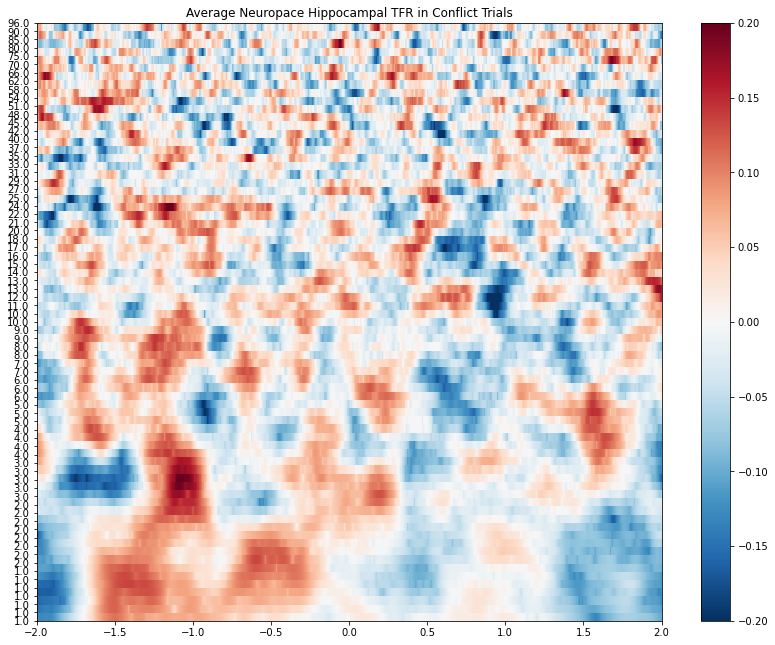

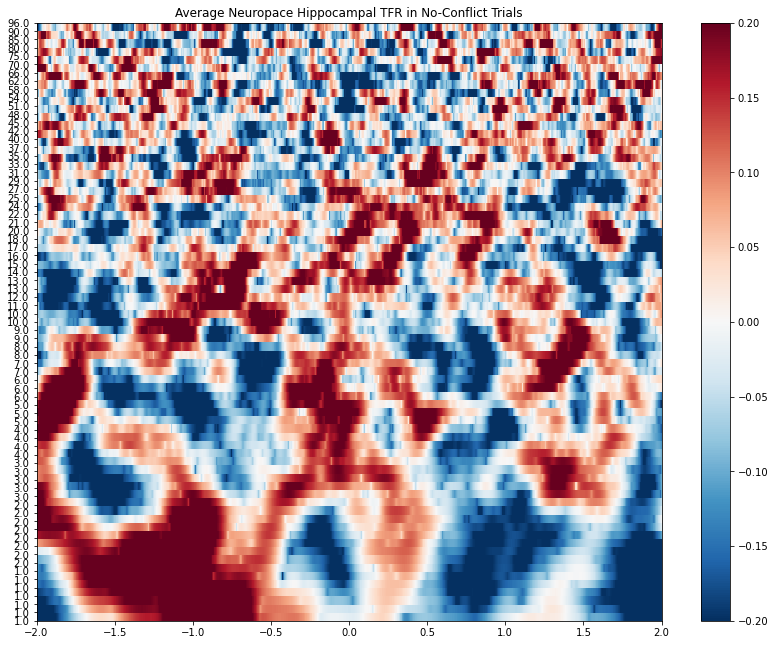

In [18]:
plt.rcParams['figure.figsize'] = [14, 11]
fig, ax = plt.subplots()
i = ax.imshow(ghost_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.2, vmax = .2)
ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
ax.set_yticklabels(np.round(ghost_TFR.freqs))
bar = plt.colorbar(i)
ax.set_title("Average Neuropace Hippocampal TFR in Conflict Trials")
fig.show()
fig.savefig('rns_average_hc_conflict.png', dpi=600)


fig, ax = plt.subplots()
i = ax.imshow(no_ghost_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.2, vmax = .2)
ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
ax.set_yticklabels(np.round(ghost_TFR.freqs))
bar = plt.colorbar(i)
ax.set_title("Average Neuropace Hippocampal TFR in No-Conflict Trials")
fig.show()
fig.savefig('rns_average_hc_noconflict.png', dpi=600)

/tmp/ipykernel_219031/3873617026.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_219031/3873617026.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


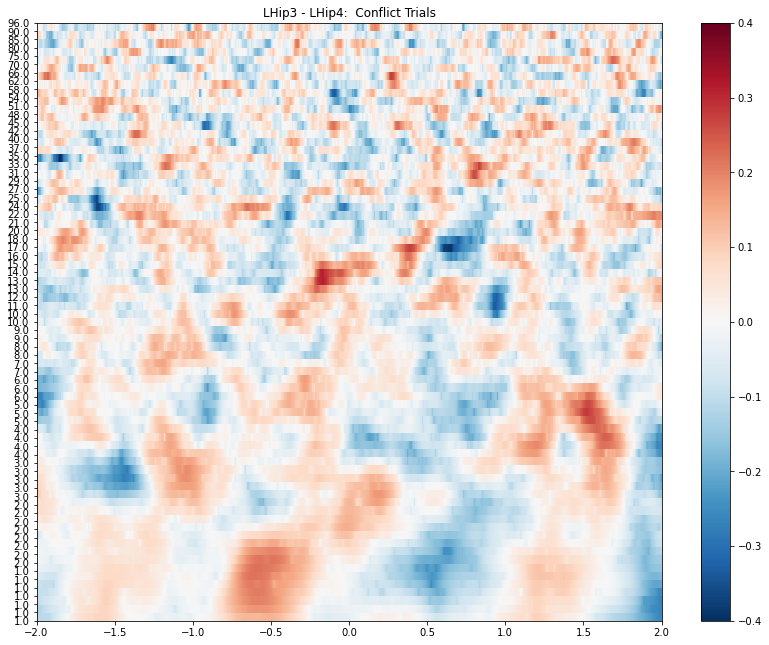

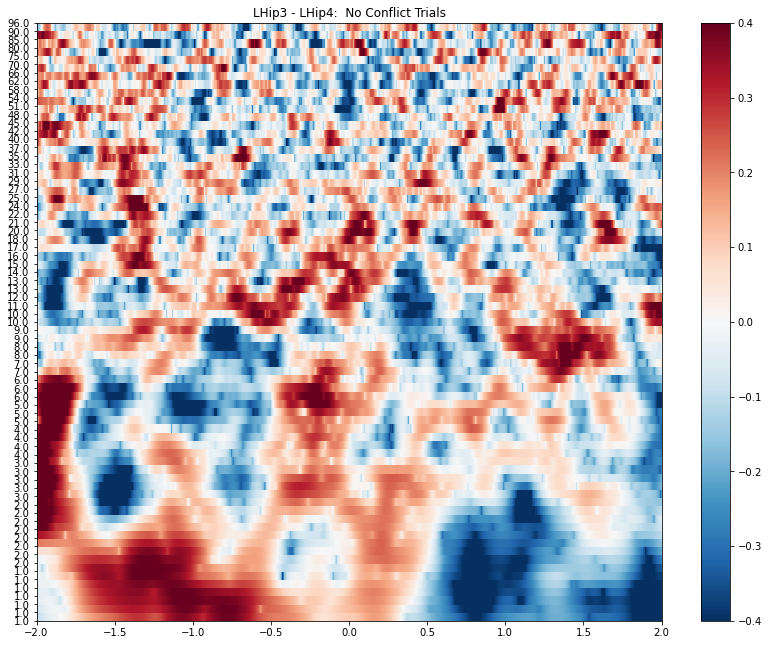

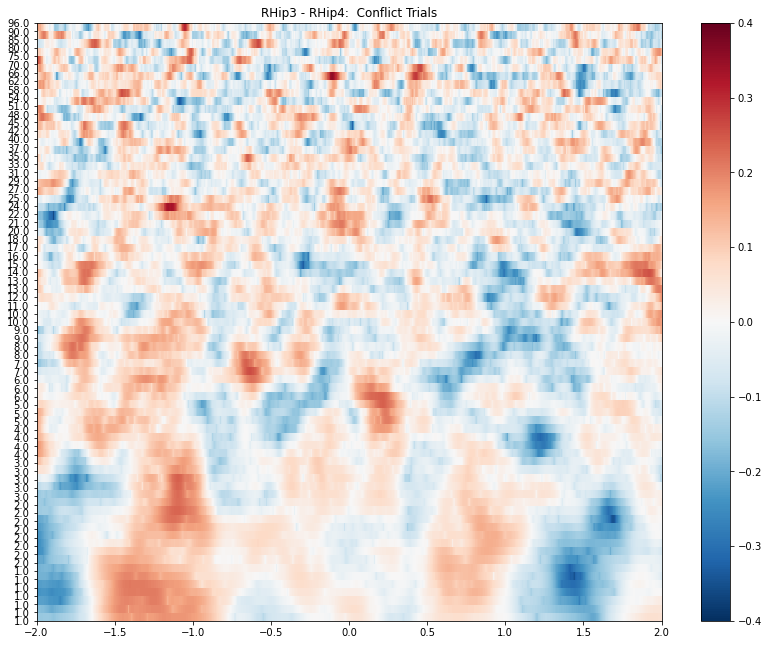

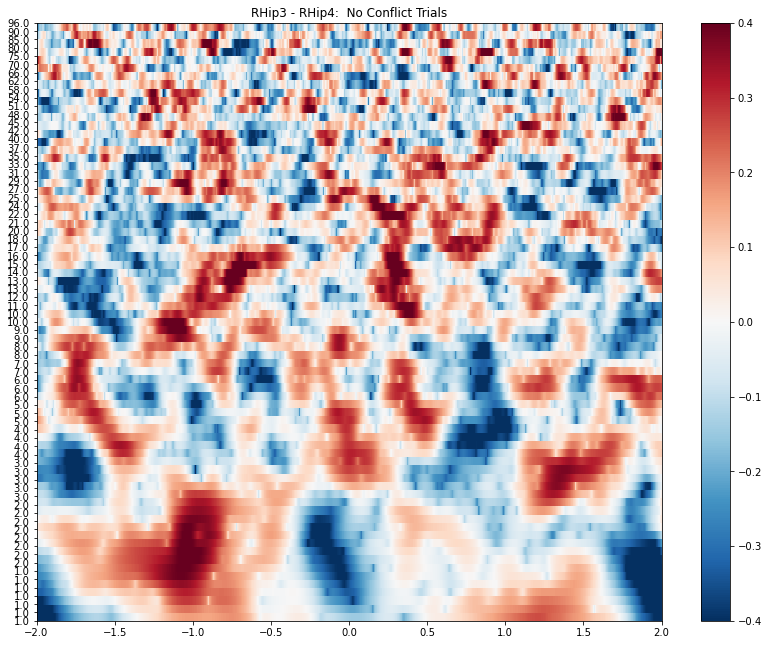

In [19]:
plt.rcParams['figure.figsize'] = [14, 11]

chix = 0
for ch in ghost_TFR.ch_names:

    fig, ax = plt.subplots()
    i = ax.imshow(ghost_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
    ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
    ax.set_yticklabels(np.round(ghost_TFR.freqs))
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}:  Conflict Trials")
    fig.show()

    fig, ax = plt.subplots()
    i = ax.imshow(no_ghost_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
    ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
    ax.set_yticklabels(np.round(ghost_TFR.freqs))
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}:  No Conflict Trials")
    fig.show()
    
    chix = chix + 1